In [1]:
import os
import numpy as np
import cv2
from pyswarm import pso

In [2]:
import os
import numpy as np
import cv2
import pandas as pd
from pyswarm import pso
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# --- Paths ---
csv_path = "D:/B.Tech/8th Sem/CI Lab/Project/Cylone_Intensity_IndianOcean/label.csv"
image_dir = "D:/B.Tech/8th Sem/CI Lab/Project/Cylone_Intensity_IndianOcean/Infrared"

In [3]:
# --- 1. Load CSV ---
df = pd.read_csv(csv_path)
df['filepath'] = df['Filename'].apply(lambda x: os.path.join(image_dir, x))
print(f"Total samples from CSV: {len(df)}")

Total samples from CSV: 15101


In [4]:
# --- 2. Extract raw features from images ---
def extract_image_features(image_path):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    image = cv2.resize(image, (64, 64)).astype(np.float32) / 255.0
    return image.flatten()

X = np.array([extract_image_features(p) for p in df['filepath']])
y = df['Vmax'].values

print(f"Raw feature shape: {X.shape}")  # (samples, features)
print(f"Labels shape: {y.shape}")

Raw feature shape: (15101, 4096)
Labels shape: (15101,)


In [5]:
# --- 4. Load saved selected feature mask ---
selected_mask = np.load("selected_features_mask.npy")
X_selected = X[:, selected_mask]
print(f"Selected features count: {np.sum(selected_mask)}")
print(f"Feature shape after PSO selection: {X_selected.shape}")

# --- Train / Val / Test Split ---
X_trainval, X_test, y_trainval, y_test = train_test_split(X_selected, y, test_size=0.15, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.15, random_state=42)

# Print shapes to confirm
print(f"X_test: {X_test.shape}, y_test: {y_test.shape}")
print(f"X_val: {X_val.shape}, y_val: {y_val.shape}")
print(f"X_train: {X_train.shape}, y_train: {y_train.shape}")

Selected features count: 2141
Feature shape after PSO selection: (15101, 2141)
X_test: (2266, 2141), y_test: (2266,)
X_val: (1926, 2141), y_val: (1926,)
X_train: (10909, 2141), y_train: (10909,)


In [14]:
X_train.shape

(10909, 2141)

In [6]:
# --- Convert to Tensors ---
def to_loader(X, y):
    X_tensor = torch.tensor(X, dtype=torch.float32)
    y_tensor = torch.tensor(y, dtype=torch.float32).unsqueeze(1)
    return DataLoader(TensorDataset(X_tensor, y_tensor), batch_size=32, shuffle=True)

train_loader = to_loader(X_train, y_train)
test_loader = to_loader(X_test, y_test)
val_loader = to_loader(X_val, y_val)

In [7]:
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import numpy as np

# ---------------- ResNet‑style MLP block ---------------- #
class ResidualBlock(nn.Module):
    def __init__(self, dim, dropout=0.1):
        super().__init__()
        self.fc1 = nn.Linear(dim, dim)
        self.bn1 = nn.BatchNorm1d(dim)
        self.fc2 = nn.Linear(dim, dim)
        self.bn2 = nn.BatchNorm1d(dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        identity = x
        out = F.relu(self.bn1(self.fc1(x)))
        out = self.dropout(out)
        out = self.bn2(self.fc2(out))
        out += identity                 # residual add
        return F.relu(out)

# ---------------- Full Model ---------------- #
class ResNetRegressor(nn.Module):
    def __init__(self, in_dim, hidden_dim=512, n_blocks=4, dropout=0.1):
        super().__init__()
        self.input_fc = nn.Linear(in_dim, hidden_dim)
        self.blocks = nn.Sequential(
            *[ResidualBlock(hidden_dim, dropout) for _ in range(n_blocks)]
        )
        self.output_fc = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        x = F.relu(self.input_fc(x))
        x = self.blocks(x)
        return self.output_fc(x)

# ---------------- Training utilities ---------------- #
def train_epoch(model, loader, crit, opt):
    model.train()
    running_loss = 0
    for xb, yb in loader:
        opt.zero_grad()
        pred = model(xb)
        loss = crit(pred, yb)
        loss.backward()
        opt.step()
        running_loss += loss.item() * xb.size(0)
    return running_loss / len(loader.dataset)

@torch.no_grad()
def eval_epoch(model, loader, crit):
    model.eval()
    running_loss = 0
    for xb, yb in loader:
        pred = model(xb)
        loss = crit(pred, yb)
        running_loss += loss.item() * xb.size(0)
    return running_loss / len(loader.dataset)

# ---------------- Prepare loaders (reuse your to_loader) ---------------- #
# train_loader, val_loader, test_loader already exist from your snippet

# ---------------- Hyper‑parameters ---------------- #
in_features = X_train.shape[1]
model = ResNetRegressor(in_dim=in_features, hidden_dim=512, n_blocks=6, dropout=0.2)
criterion = nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)
epochs = 50

train_losses, val_losses = [], []

In [15]:
train_loader.shape


AttributeError: 'DataLoader' object has no attribute 'shape'

In [8]:
# ---------------- Training loop ---------------- #
for epoch in range(1, epochs + 1):
    t0 = time.time()
    tr_loss = train_epoch(model, train_loader, criterion, optimizer)
    vl_loss = eval_epoch(model, val_loader, criterion)
    dt = time.time() - t0
    train_losses.append(tr_loss)
    val_losses.append(vl_loss)
    print(f"Epoch {epoch:03d}/{epochs} | "
          f"train MSE: {tr_loss:.4f} | val MSE: {vl_loss:.4f} | time: {dt:.1f}s")

Epoch 001/50 | train MSE: 767.1376 | val MSE: 1148.4326 | time: 767.6s
Epoch 002/50 | train MSE: 618.8123 | val MSE: 615.1009 | time: 55.5s
Epoch 003/50 | train MSE: 586.5869 | val MSE: 579.0766 | time: 50.7s
Epoch 004/50 | train MSE: 576.6300 | val MSE: 517.5595 | time: 41.8s
Epoch 005/50 | train MSE: 537.3572 | val MSE: 889.5443 | time: 50.3s
Epoch 006/50 | train MSE: 515.2414 | val MSE: 720.2906 | time: 48.0s
Epoch 007/50 | train MSE: 499.7390 | val MSE: 758.6344 | time: 19.1s
Epoch 008/50 | train MSE: 477.7647 | val MSE: 1142.2070 | time: 27.8s
Epoch 009/50 | train MSE: 456.7744 | val MSE: 853.0214 | time: 135.2s
Epoch 010/50 | train MSE: 454.1933 | val MSE: 714.0079 | time: 942.9s
Epoch 011/50 | train MSE: 426.0318 | val MSE: 469.6753 | time: 56.4s
Epoch 012/50 | train MSE: 420.6361 | val MSE: 807.7935 | time: 32.6s
Epoch 013/50 | train MSE: 404.8323 | val MSE: 1012.1245 | time: 30.5s
Epoch 014/50 | train MSE: 394.7710 | val MSE: 541.8700 | time: 31.2s
Epoch 015/50 | train MSE: 38

In [9]:
# ---------------- Metrics on all splits ---------------- #
def get_metrics(loader, name):
    y_true, y_pred = [], []
    with torch.no_grad():
        for xb, yb in loader:
            y_true.append(yb.numpy())
            y_pred.append(model(xb).numpy())
    y_true = np.vstack(y_true)
    y_pred = np.vstack(y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    r2  = r2_score(y_true, y_pred)
    print(f"{name:>5} | MAE: {mae:.3f} | MSE: {mse:.3f} | R²: {r2:.3f}")
    return mae, mse, r2
    
print("\n--- Final evaluation ---")
get_metrics(train_loader, "Train")
get_metrics(val_loader,   "Val")
get_metrics(test_loader,  "Test")


--- Final evaluation ---
Train | MAE: 15.608 | MSE: 503.393 | R²: 0.575
  Val | MAE: 19.938 | MSE: 750.728 | R²: 0.378
 Test | MAE: 20.853 | MSE: 804.218 | R²: 0.318


(20.853018, 804.2184, 0.3178338417549721)

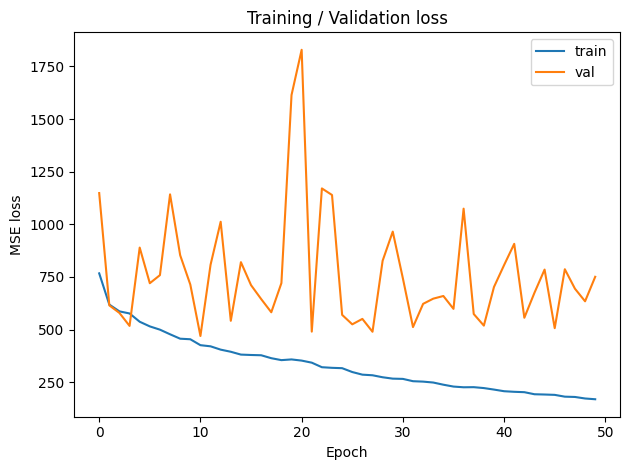

Model weights saved to resnet_regressor_state_dict.pt


In [10]:

# ---------------- Plot loss curves ---------------- #
plt.figure()
plt.plot(train_losses, label="train")
plt.plot(val_losses,   label="val")
plt.xlabel("Epoch")
plt.ylabel("MSE loss")
plt.legend()
plt.title("Training / Validation loss")
plt.tight_layout()
plt.show()

# ---------------- Save model ---------------- #
torch.save(model.state_dict(), "resnet_regressor_state_dict.pt")
print("Model weights saved to resnet_regressor_state_dict.pt")

In [13]:
import matplotlib.pyplot as plt
from PIL import Image
import torchvision.transforms as T
import torch

# ---------- 1.  Reload model ----------
in_features = X_selected.shape[1]           # same input dimensionality
model = ResNetRegressor(in_dim=in_features)
model.load_state_dict(torch.load("resnet_regressor_state_dict.pt"))
model.eval()

# ---------- 2.  Choose an image ----------
# If you know the filename directly:
img_path = "D:/B.Tech/8th Sem/CI Lab/Project/Cylone_Intensity_IndianOcean/Infrared/IN_1.png"        # <-- put any test image path here

# ...or pick by index in your dataframe:
# idx = 10                                   # choose index inside X_test
# img_path = df.iloc[idx]["Filename"]

img = Image.open(img_path).convert("L")     # IR images are single‑channel

# ---------- 3.  Pre‑process / predict ----------
# (Assuming you already have feature extraction → PSO mask code wrapped in a function.)
def extract_pso_features(img_pil):
    """
    Returns a 1D numpy array of length = all_features,
    then masks it with selected_mask to match model input.
    """
    # example basic transform – adapt to your pipeline!
    transform = T.Compose([
        T.Resize((64,64)),
        T.ToTensor(),                       # (1,H,W) float32 in [0,1]
    ])
    feat = transform(img_pil).flatten().numpy()
    return feat[selected_mask]              # shape (2141,)

# feature vector for this image
feat_vec = extract_pso_features(img)
feat_tensor = torch.tensor(feat_vec, dtype=torch.float32).unsqueeze(0)  # (1,2141)

with torch.no_grad():
    vmax_pred = model(feat_tensor).item()

# optional: get ground‑truth from your dataframe
try:
    true_vmax = df.loc[df["Filename"] == img_path, "Vmax"].values[0]
except Exception:
    true_vmax = None

# ---------- 4.  Display ----------
plt.figure(figsize=(4,4))
plt.imshow(img, cmap="gray")
title = f"Predicted Vmax: {vmax_pred:.1f} kt"
if true_vmax is not None:
    title += f"\nTrue Vmax: {true_vmax:.1f} kt"
plt.title(title)
plt.axis("off")
plt.show()


C:\Users\satvi\AppData\Local\Temp\ipykernel_17452\1529918433.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("resnet_regressor_state_dic

RuntimeError: Error(s) in loading state_dict for ResNetRegressor:
	Unexpected key(s) in state_dict: "blocks.4.fc1.weight", "blocks.4.fc1.bias", "blocks.4.bn1.weight", "blocks.4.bn1.bias", "blocks.4.bn1.running_mean", "blocks.4.bn1.running_var", "blocks.4.bn1.num_batches_tracked", "blocks.4.fc2.weight", "blocks.4.fc2.bias", "blocks.4.bn2.weight", "blocks.4.bn2.bias", "blocks.4.bn2.running_mean", "blocks.4.bn2.running_var", "blocks.4.bn2.num_batches_tracked", "blocks.5.fc1.weight", "blocks.5.fc1.bias", "blocks.5.bn1.weight", "blocks.5.bn1.bias", "blocks.5.bn1.running_mean", "blocks.5.bn1.running_var", "blocks.5.bn1.num_batches_tracked", "blocks.5.fc2.weight", "blocks.5.fc2.bias", "blocks.5.bn2.weight", "blocks.5.bn2.bias", "blocks.5.bn2.running_mean", "blocks.5.bn2.running_var", "blocks.5.bn2.num_batches_tracked". 